<a href="https://colab.research.google.com/github/me912/Human-activity-recognize/blob/main/train_model/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
#!pip install keras==2.3.1
%tensorflow==2.2

UsageError: Line magic function `%tensorflow` not found.


In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, AveragePooling1D, AveragePooling2D
from tensorflow.keras.layers import LSTM, Conv1D
from tensorflow.keras.utils import to_categorical

import os

In [ ]:
print(tf.__version__)

2.6.0


In [ ]:
#Các feature
INPUT_SIGNAL_TYPES = [
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_"
]

# Các lớp phân loại
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]

In [ ]:
folder = "./gdrive/MyDrive/project1/dataset/"

# Load "X" (the neural network's training and testing inputs)


In [ ]:
# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values

In [ ]:
# load a list of files into a 3D array of [samples, timesteps, features]
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded

In [ ]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

In [ ]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
	# load all train
	trainX, trainy = load_dataset_group('train', prefix )
	#print("trainX.shape: {}, trainy.shape: {}".format(trainX.shape, trainy.shape))
	# load all test
	testX, testy = load_dataset_group('test', prefix )
	#print(testX.shape, testy.shape)
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
	print("trainX.shape: {}\ntrainy.shape: {}\ntestX.shape: {}\ntesty.shape: {}".format(trainX.shape, trainy.shape, testX.shape, testy.shape))
	return trainX, trainy, testX, testy

In [ ]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
  verbose, epochs, batch_size = 0, 100, 64
  n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
  EarlyStop = callbacks.EarlyStopping(min_delta=0.001, patience=20, restore_best_weights=True)
  model = Sequential()
  model.add(LSTM(25, input_shape=(n_timesteps,n_features),  return_sequences=True))
  model.add(Conv1D(25, activation="relu", kernel_size=3, padding="same"))
  model.add(AveragePooling1D(pool_size=2))
  model.add(MaxPooling1D(pool_size=5))
  model.add(Flatten())
  model.add(Dense(30, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(20, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax'))
  model.summary()
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit network

  history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(testX, testy), callbacks=[EarlyStop])
	# evaluate model
  _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
  return model, accuracy, history


In [ ]:
# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))


In [ ]:
def run_experiment(repeats=10):
	# load data
	trainX, trainy, testX, testy = load_dataset(folder)
	# repeat experiment
	scores = list()
	for r in range(repeats):
		score = evaluate_model(trainX, trainy, testX, testy)
		score = score * 100.0
		print('>#%d: %.3f' % (r+1, score))
		scores.append(score)
	# summarize results
	summarize_results(scores)


In [ ]:
trainX, trainy, testX, testy = load_dataset(folder)

trainX.shape: (7352, 128, 9)
trainy.shape: (7352, 6)
testX.shape: (2947, 128, 9)
testy.shape: (2947, 6)


In [ ]:
print(trainX[0, :, 2])

[0.1029341  0.1056872  0.1021025  0.1065527  0.1028135  0.1074931
 0.1093857  0.1038862  0.1024732  0.0975659  0.09764665 0.09537356
 0.09367106 0.09921876 0.09997368 0.09889572 0.0962825  0.09765831
 0.1004408  0.09846986 0.1015699  0.1021059  0.1005147  0.1021144
 0.100956   0.1014768  0.1014304  0.1000858  0.09980876 0.09743248
 0.09520512 0.09369074 0.09435198 0.09595278 0.0986602  0.1049836
 0.1066249  0.1064143  0.109485   0.107602   0.1030893  0.1005282
 0.09970745 0.1006193  0.1000773  0.1021935  0.107519   0.108948
 0.107225   0.1045164  0.102301   0.09824694 0.09383632 0.1008436
 0.1089435  0.1037146  0.1004966  0.1040357  0.1024968  0.1001817
 0.1002736  0.09922501 0.09939194 0.0985878  0.09792958 0.09935086
 0.09811381 0.09751712 0.0974719  0.09657678 0.09774064 0.09730921
 0.09815882 0.1011657  0.1016211  0.1015734  0.1011669  0.1013595
 0.1011384  0.09923839 0.1005806  0.1025034  0.1001684  0.09859667
 0.1007798  0.1003598  0.09920002 0.1017142  0.101472   0.1012259
 0.10

WALKING


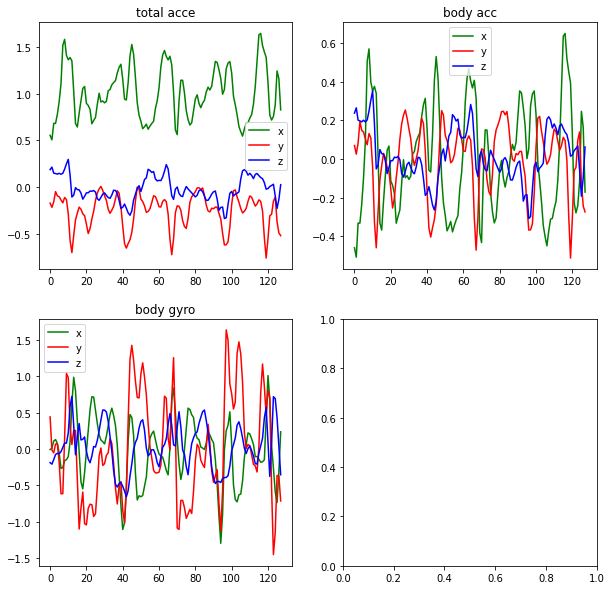

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
index = 100
print(LABELS[np.argmax(trainy[index])])
ax[0, 0].plot(np.arange(0, 128, 1), trainX[index, :, 0], 'g', label="x")
ax[0, 0].plot(np.arange(0, 128, 1), trainX[index, :, 1], 'r', label="y")
ax[0, 0].plot(np.arange(0, 128, 1), trainX[index, :, 2], 'b', label="z")
ax[0, 0].set_title("total acce")
ax[0, 0].legend(loc='best')

ax[0, 1].plot(np.arange(0, 128, 1), trainX[index, :, 3], 'g', label="x")
ax[0, 1].plot(np.arange(0, 128, 1), trainX[index, :, 4], 'r', label="y")
ax[0, 1].plot(np.arange(0, 128, 1), trainX[index, :, 5], 'b', label="z")
ax[0, 1].set_title("body acc")
ax[0, 1].legend(loc='best')

ax[1, 0].plot(np.arange(0, 128, 1), trainX[index, :, 6], 'g', label="x")
ax[1, 0].plot(np.arange(0, 128, 1), trainX[index, :, 7], 'r', label="y")
ax[1, 0].plot(np.arange(0, 128, 1), trainX[index, :, 8], 'b', label="z")
ax[1, 0].set_title("body gyro")
ax[1, 0].legend(loc='best')




In [ ]:
model, score, history = evaluate_model(trainX, trainy, testX, testy)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 128, 25)           3500      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 128, 25)           1900      
_________________________________________________________________
average_pooling1d_6 (Average (None, 64, 25)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 12, 25)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 300)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 30)                9030      
_________________________________________________________________
dropout_3 (Dropout)          (None, 30)               

In [ ]:
summarize_results(score)

0.9009161591529846
Accuracy: 0.901% (+/-0.000)


In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 128, 25)           3500      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 128, 25)           1900      
_________________________________________________________________
average_pooling1d_5 (Average (None, 12, 25)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 300)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 30)                9030      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 20)               

In [ ]:
model.save("modelv7.h5")

# Mục mới

In [ ]:
print(keras.__version__)

2.4.3


In [ ]:
import tensorflow as tf


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

model_name = "modelv4"

open(model_name + '.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp7cwmuxzx/assets


INFO:tensorflow:Assets written to: /tmp/tmp7cwmuxzx/assets


53056

In [ ]:
model.predict(testX[0])

NameError: ignored

In [ ]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

In [ ]:
# Write TFLite model to a C source (or header) file
c_model_name = "train_modelv3"
with open(c_model_name + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, c_model_name))

In [ ]:
modelv4 = tf.keras.models.load_model("modelv4.h5")
modelv5 = tf.keras.models.load_model("modelv5.h5")
modelv6 = tf.keras.models.load_model("modelv6.h5")
modelv7 = tf.keras.models.load_model("modelv7.h5")

In [ ]:
modelv4.summary()
modelv4.evaluate(testX, testy)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 128, 35)           6300      
_________________________________________________________________
lstm_28 (LSTM)               (None, 25)                6100      
_________________________________________________________________
flatten_8 (Flatten)          (None, 25)                0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 30)                780       
_________________________________________________________________
dense_25 (Dense)             (None, 20)                620       
_________________________________________________________________
dense_26 (Dense)             (None, 6)                

[0.37927448749542236, 0.913810670375824]

In [ ]:
modelv6.summary()
modelv6.evaluate(testX, testy)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128, 25)           3500      
_________________________________________________________________
average_pooling1d (AveragePo (None, 25, 25)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 25)                5100      
_________________________________________________________________
flatten (Flatten)            (None, 25)                0         
_________________________________________________________________
dense (Dense)                (None, 30)                780       
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                6

[0.4169643223285675, 0.9222938418388367]

In [ ]:
modelv7.summary()
modelv7.evaluate(testX, testy)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128, 25)           3500      
_________________________________________________________________
average_pooling1d_1 (Average (None, 25, 25)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 25)                5100      
_________________________________________________________________
flatten_1 (Flatten)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 30)                780       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)               

[0.7968264818191528, 0.8978622555732727]

In [ ]:
model.summary()
model.evaluate(testX, testy)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128, 25)           3500      
_________________________________________________________________
average_pooling1d (AveragePo (None, 25, 25)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 25)                5100      
_________________________________________________________________
flatten (Flatten)            (None, 25)                0         
_________________________________________________________________
dense (Dense)                (None, 30)                780       
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                6

[0.9213133454322815, 0.9134713411331177]